In [1]:
import numpy as np 
import pandas as pd

from scipy.stats import ttest_ind, f_oneway
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans

# Data Preprocessing

In [2]:
# List all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv
/kaggle/input/gene-expression/data_set_ALL_AML_train.csv
/kaggle/input/gene-expression/actual.csv


### Load Data

In [3]:
# Load training dataset
df_train = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_train.csv')
# Load test dataset
df_test = pd.read_csv('/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv')
# Load labels
y = pd.read_csv('/kaggle/input/gene-expression/actual.csv')

print(df_train.shape)
print(df_test.shape)
print(y.shape)

(7129, 78)
(7129, 70)
(72, 2)


In [4]:
y.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [5]:
# Check for nulls
null_counts_y = y.isnull().sum().max()

print('Columns with Null Values:')
print(null_counts_y)

Columns with Null Values:
0


In [6]:
# Check for the patient count in each category
y['cancer'].value_counts()

cancer
ALL    47
AML    25
Name: count, dtype: int64

In [7]:
# Make the labels numeric
y = y.replace({'ALL':0,'AML':1})
y.head()

<ipython-input-7-ce7e70f42286>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'ALL':0,'AML':1})


,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [8]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [9]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


### Clean Data

In [10]:
# Remove call columns from training and test data assuming they are not very significant as no explanation is provided in the paper. 
columns_to_keep_train = [col for col in df_train.columns if "call" not in col]
columns_to_keep_test = [col for col in df_test.columns if "call" not in col]

df_train_optimised = df_train[columns_to_keep_train] 
df_test_optimised = df_test[columns_to_keep_test]

In [11]:
# Transpose columns and rows so that genes become features and each row corresponds to a patient
df_train_optimised = df_train_optimised.T
df_test_optimised = df_test_optimised.T

In [12]:
df_train_optimised.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [13]:
# Simplify the second row into column names and remove the first row
df_train_optimised.columns = df_train_optimised.iloc[1]
df_test_optimised.columns = df_test_optimised.iloc[1]
df_train_optimised = df_train_optimised.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)
df_test_optimised = df_test_optimised.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(df_train_optimised.shape)
print(df_test_optimised.shape)
df_train_optimised.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [14]:
# Reset the indexes
df_train_optimised = df_train_optimised.reset_index(drop=True)
df_test_optimised = df_test_optimised.reset_index(drop=True)

df_train_optimised.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [15]:
# Check for nulls
null_counts_x = df_train_optimised.isnull().sum().max()

print('Columns with Null Values:')
print(null_counts_x)

Columns with Null Values:
0


In [16]:
# Scalling train data
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training data
scaler.fit(df_train_optimised)

# Transform both training and test data
train_scaled = scaler.transform(df_train_optimised)
test_scaled = scaler.transform(df_test_optimised)

# Convert back to DataFrames with original column names
df_train_scaled = pd.DataFrame(train_scaled, columns=df_train_optimised.columns)
df_test_scaled = pd.DataFrame(test_scaled, columns=df_test_optimised.columns)

# Check the result
df_train_scaled.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-0.861496,-0.033101,-0.351701,-0.805738,-0.168417,-0.888716,1.120068,0.280962,1.863470,0.449110,...,0.074511,-0.815620,-1.758717,-0.021865,-0.405584,-0.159782,-0.033046,0.546068,-0.435820,-0.255875
1,-0.167723,1.037400,0.139139,0.876572,0.114600,0.293351,-1.322502,0.370212,0.023726,-0.182439,...,-0.116640,0.292993,-0.589006,0.092516,0.073055,-0.182892,-0.197260,-0.267043,-0.595744,0.499648
2,0.415047,1.358550,-2.495899,1.100880,-0.907912,-1.577008,0.353591,-1.849884,1.303018,-1.565148,...,1.627617,1.524030,0.317849,-0.498816,1.724361,0.565043,2.130709,0.708690,-0.384366,-0.387270
3,-0.130721,0.488768,2.429729,-1.461407,-1.300484,-1.090715,0.930757,-0.578070,-0.609828,-0.388171,...,0.731595,0.286192,2.749271,-0.485868,-2.152617,-0.508538,-0.800986,-2.251033,-0.526212,-2.029712
4,0.137537,0.341574,-0.506703,-0.115559,0.425006,1.161198,0.219688,0.883400,-0.353970,0.669195,...,-0.271951,-0.346330,0.633277,0.226322,-0.142332,-1.300593,-0.105493,-0.169469,-0.623557,0.138311


### Statistical Analysis of Gene Expression Using T-test

In [17]:
# Split the train and test labels
y_train = y[y.patient <= 38].reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

print(y_train.shape)
print(y_test.shape)

(38, 2)
(34, 2)


In [18]:
# Merge train labels
df_train_scaled_merged = pd.concat([df_train_scaled, y_train], axis=1)
df_train_scaled_merged.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-0.861496,-0.033101,-0.351701,-0.805738,-0.168417,-0.888716,1.120068,0.280962,1.863470,0.449110,...,-1.758717,-0.021865,-0.405584,-0.159782,-0.033046,0.546068,-0.435820,-0.255875,1,0
1,-0.167723,1.037400,0.139139,0.876572,0.114600,0.293351,-1.322502,0.370212,0.023726,-0.182439,...,-0.589006,0.092516,0.073055,-0.182892,-0.197260,-0.267043,-0.595744,0.499648,2,0
2,0.415047,1.358550,-2.495899,1.100880,-0.907912,-1.577008,0.353591,-1.849884,1.303018,-1.565148,...,0.317849,-0.498816,1.724361,0.565043,2.130709,0.708690,-0.384366,-0.387270,3,0
3,-0.130721,0.488768,2.429729,-1.461407,-1.300484,-1.090715,0.930757,-0.578070,-0.609828,-0.388171,...,2.749271,-0.485868,-2.152617,-0.508538,-0.800986,-2.251033,-0.526212,-2.029712,4,0
4,0.137537,0.341574,-0.506703,-0.115559,0.425006,1.161198,0.219688,0.883400,-0.353970,0.669195,...,0.633277,0.226322,-0.142332,-1.300593,-0.105493,-0.169469,-0.623557,0.138311,5,0


In [19]:
# Merge test labels
df_test_scaled_merged = pd.concat([df_test_scaled, y_test], axis=1)
df_test_scaled_merged.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-2.045535,-0.662020,0.500811,1.264797,0.479783,0.091352,-2.827752,-1.013165,0.462341,-1.225451,...,0.764705,-0.399542,-2.750916,0.430582,0.672106,0.936361,-0.467805,-1.339886,39,0
1,0.313293,-1.304321,2.403895,0.980099,0.461524,-0.402422,1.895780,-2.798166,1.156813,0.238594,...,-3.992997,-0.101717,-1.123542,-1.685065,-0.351814,-1.698117,-0.747324,0.269706,40,0
2,1.321577,-0.033101,0.294142,0.816181,0.598468,1.415566,0.455172,0.671431,-1.206831,1.855741,...,0.094421,0.342862,1.054266,0.050312,-0.187600,-0.429665,2.039525,-0.420119,41,0
3,-1.129755,-0.902883,-1.255881,0.005222,-0.113639,1.280901,-1.114722,0.325587,-0.573277,-1.177607,...,-0.037007,-0.686575,0.527763,-0.308949,-0.800986,-0.624811,0.007795,-1.438433,42,0
4,-0.084470,-0.354251,-0.093364,0.729909,0.972780,0.846977,-0.823830,1.206931,-1.084994,0.224240,...,0.554420,0.109782,-0.620971,-0.540052,0.164976,0.318397,-0.238349,0.335404,43,0


In [20]:
# Combine train and test data
df_combined = pd.concat([df_train_scaled_merged, df_test_scaled_merged], ignore_index=True, axis=0)
print(df_combined.shape)
df_combined.head()

(72, 7131)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-0.861496,-0.033101,-0.351701,-0.805738,-0.168417,-0.888716,1.120068,0.280962,1.863470,0.449110,...,-1.758717,-0.021865,-0.405584,-0.159782,-0.033046,0.546068,-0.435820,-0.255875,1,0
1,-0.167723,1.037400,0.139139,0.876572,0.114600,0.293351,-1.322502,0.370212,0.023726,-0.182439,...,-0.589006,0.092516,0.073055,-0.182892,-0.197260,-0.267043,-0.595744,0.499648,2,0
2,0.415047,1.358550,-2.495899,1.100880,-0.907912,-1.577008,0.353591,-1.849884,1.303018,-1.565148,...,0.317849,-0.498816,1.724361,0.565043,2.130709,0.708690,-0.384366,-0.387270,3,0
3,-0.130721,0.488768,2.429729,-1.461407,-1.300484,-1.090715,0.930757,-0.578070,-0.609828,-0.388171,...,2.749271,-0.485868,-2.152617,-0.508538,-0.800986,-2.251033,-0.526212,-2.029712,4,0
4,0.137537,0.341574,-0.506703,-0.115559,0.425006,1.161198,0.219688,0.883400,-0.353970,0.669195,...,0.633277,0.226322,-0.142332,-1.300593,-0.105493,-0.169469,-0.623557,0.138311,5,0


In [21]:
# Create separate dataframes for ALL and AML patients
df_merged_ALL = df_combined[df_combined['cancer'] == 0]
df_merged_AML = df_combined[df_combined['cancer'] == 1]

print(df_merged_ALL.shape)
print(df_merged_AML.shape)

(47, 7131)
(25, 7131)


In [22]:
# Remove labels to perform t-test
df_ALL = df_merged_ALL.drop(['patient', 'cancer'], axis=1)
df_AML = df_merged_AML.drop(['patient', 'cancer'], axis=1)

df_ALL.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-0.861496,-0.033101,-0.351701,-0.805738,-0.168417,-0.888716,1.120068,0.280962,1.863470,0.449110,...,0.074511,-0.815620,-1.758717,-0.021865,-0.405584,-0.159782,-0.033046,0.546068,-0.435820,-0.255875
1,-0.167723,1.037400,0.139139,0.876572,0.114600,0.293351,-1.322502,0.370212,0.023726,-0.182439,...,-0.116640,0.292993,-0.589006,0.092516,0.073055,-0.182892,-0.197260,-0.267043,-0.595744,0.499648
2,0.415047,1.358550,-2.495899,1.100880,-0.907912,-1.577008,0.353591,-1.849884,1.303018,-1.565148,...,1.627617,1.524030,0.317849,-0.498816,1.724361,0.565043,2.130709,0.708690,-0.384366,-0.387270
3,-0.130721,0.488768,2.429729,-1.461407,-1.300484,-1.090715,0.930757,-0.578070,-0.609828,-0.388171,...,0.731595,0.286192,2.749271,-0.485868,-2.152617,-0.508538,-0.800986,-2.251033,-0.526212,-2.029712
4,0.137537,0.341574,-0.506703,-0.115559,0.425006,1.161198,0.219688,0.883400,-0.353970,0.669195,...,-0.271951,-0.346330,0.633277,0.226322,-0.142332,-1.300593,-0.105493,-0.169469,-0.623557,0.138311


In [23]:
# Perform t-test for each gene
results = []
for gene in df_ALL.columns:
    t_value, p_value = ttest_ind(df_ALL[gene], df_AML[gene], equal_var=False)
    results.append((gene, t_value, p_value))

# Convert results list to DataFrame
df_results = pd.DataFrame(results, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# Adjust p-values for multiple testing using False Discovery Rate correction
rejected, adjusted_p_values = fdrcorrection(df_results['P_Value'])
df_results.head()

,Gene Accession Number,T_Value,P_Value
0,AFFX-BioB-5_at,-1.025408,0.309136
1,AFFX-BioB-M_at,-1.379648,0.172679
2,AFFX-BioB-3_at,-1.011032,0.315506
3,AFFX-BioC-5_at,-2.422568,0.018676
4,AFFX-BioC-3_at,0.029392,0.976665


In [24]:
# Get the list of significant genes based on the p value of 5%
significant_genes = df_results[rejected & (adjusted_p_values < 0.05)]

# Sort significant genes based on p-values
significant_genes = significant_genes.sort_values(by='P_Value')

# Add rank to significant genes DataFrame
significant_genes['Rank'] = significant_genes['P_Value'].rank()

# Display the results
print("Total Genes: 7129")
print("Significant Genes (T-test):", len(significant_genes))

Total Genes: 7129
Significant Genes (T-test): 34


In [25]:
# Sorted list of highest significant genes for classifying the cancer types
significant_genes.head()

,Gene Accession Number,T_Value,P_Value,Rank
3300,U49248_at,5.074976,0.000004,1.0
4534,X74262_at,4.800367,0.000009,2.0
5253,D38073_at,4.759275,0.000010,3.0
5351,M69181_at,4.597115,0.000022,4.0
1305,L13278_at,4.549869,0.000022,5.0


In [26]:
significant_genes_accession_numbers = significant_genes['Gene Accession Number']
# Extracting gene expression data
significant_genes_data_ALL = df_merged_ALL[significant_genes_accession_numbers]
significant_genes_data_AML = df_merged_AML[significant_genes_accession_numbers]

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


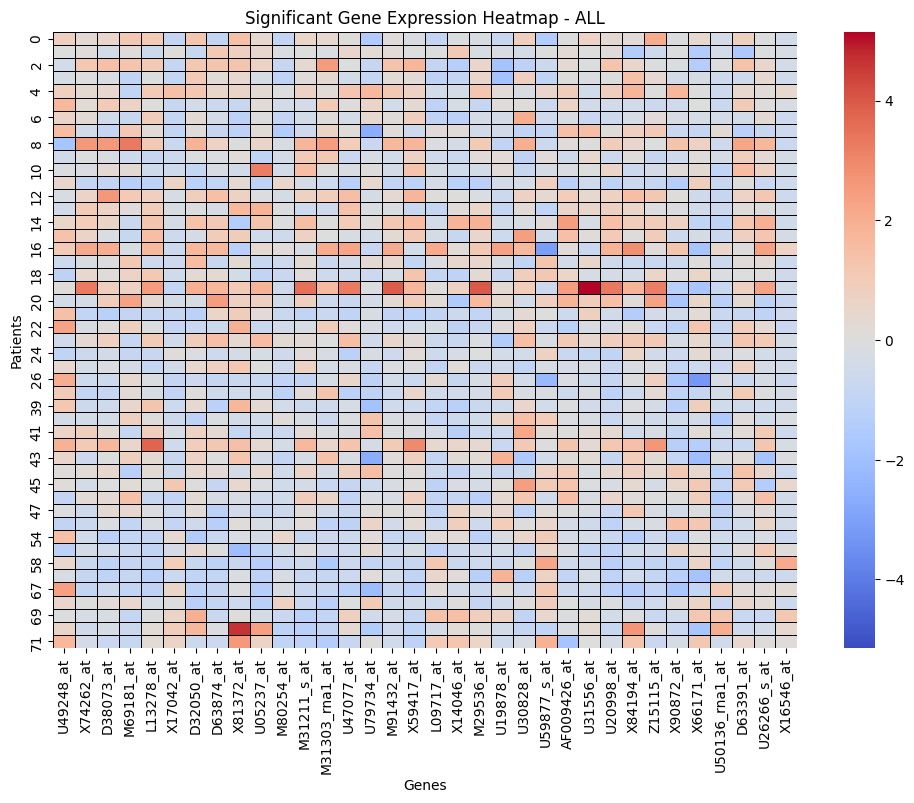

In [27]:
# Using the same maximum absolute value of ALL and AML genes intensities for comparion.
max_ALL = max(abs(significant_genes_data_ALL.values.max()), abs(significant_genes_data_ALL.values.min()))

# Heatmap for AML patients with signigicant gene intensity(scaled) values
plt.figure(figsize=(12, 8))
sns.heatmap(significant_genes_data_ALL, cmap='coolwarm', linewidths=0.5, linecolor='black', vmin=-max_ALL, vmax=max_ALL, center=0)
plt.title('Significant Gene Expression Heatmap - ALL')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


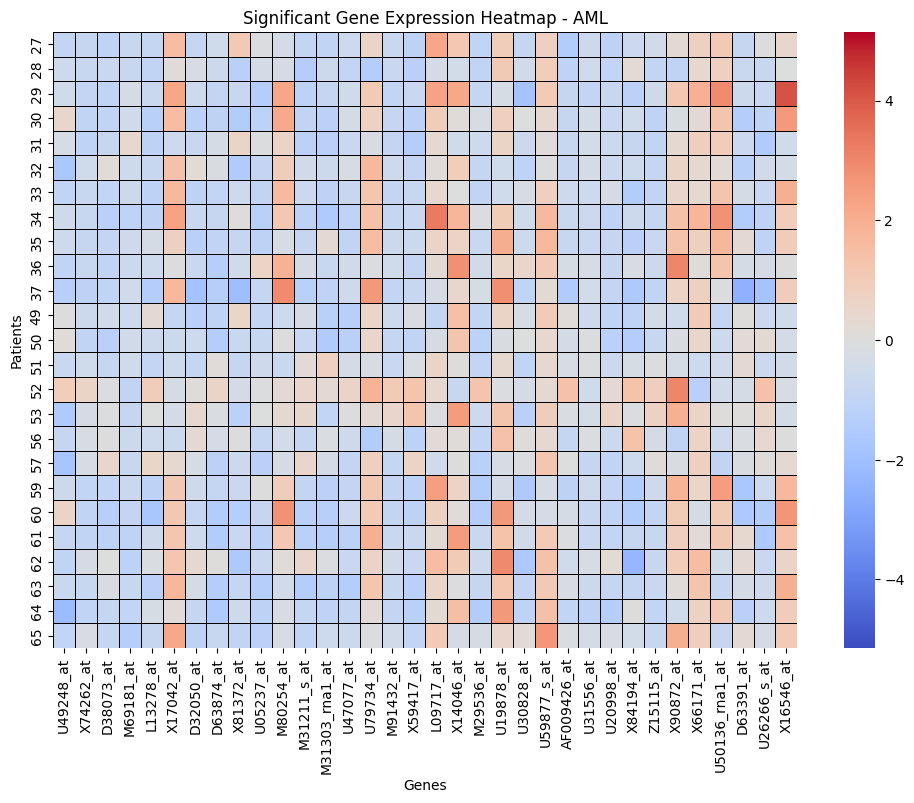

In [28]:
max_AML = max(abs(significant_genes_data_ALL.values.max()), abs(significant_genes_data_ALL.values.min()))
# Heatmap for AML patients with signigicant gene intensity(scaled) values
plt.figure(figsize=(12, 8))
sns.heatmap(significant_genes_data_AML, cmap='coolwarm', linewidths=0.5, linecolor='black', vmin=-max_AML, vmax=max_AML, center=0)
plt.title('Significant Gene Expression Heatmap - AML')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

# Classfication

In [29]:
# Select the significant genes as the feature set 
df_significant_gene_train = df_train_scaled[significant_genes['Gene Accession Number']]
df_significant_gene_test = df_test_scaled[significant_genes['Gene Accession Number']]
print(df_significant_gene_train.shape)
print(df_significant_gene_test.shape)
df_significant_gene_train.head()

(38, 34)
(34, 34)


Gene Accession Number,U49248_at,X74262_at,D38073_at,M69181_at,L13278_at,X17042_at,D32050_at,D63874_at,X81372_at,U05237_at,...,U31556_at,U20998_at,X84194_at,Z15115_at,X90872_at,X66171_at,U50136_rna1_at,D63391_at,U26266_s_at,X16546_at
0,0.837601,0.301921,0.520119,1.201059,1.039861,-0.921548,1.244235,-0.978053,1.410607,0.402562,...,0.646659,0.290436,0.187632,2.051335,-0.058534,0.347007,-0.360132,0.767614,-0.041053,-0.480675
1,-0.031526,0.106989,-0.422726,0.093433,-0.612535,0.071034,-0.787903,1.103572,0.768837,0.482235,...,-0.001344,0.135813,-1.434903,-0.595946,-0.048735,-1.485748,-0.431601,-1.624227,-0.044148,-0.241526
2,-0.430854,1.182224,1.446388,1.316374,1.090861,-0.849288,1.144060,1.263351,1.267992,0.740636,...,-0.047054,1.322616,0.461863,-0.109826,-0.141823,-1.389974,-0.044289,1.337763,0.447997,-0.388558
3,-0.266425,-0.030915,-0.130548,-1.020262,-0.000537,-0.856545,1.041839,0.239135,0.412298,-0.254208,...,-0.106208,0.017031,1.375967,0.353975,-0.367192,-0.305994,-0.569927,-0.556242,0.376806,-0.521419
4,0.825856,0.299847,0.428943,-0.995985,1.050061,1.435191,1.139971,0.546034,0.585474,0.286281,...,-0.431554,0.848509,1.798740,0.014747,1.734621,0.020507,-0.586065,0.414400,0.191091,0.401518


In [30]:
def train_classifiers(tune_model_func):
    # Example: Test with top 10, 15, 20, 25, 30 and 34 genes
    gene_sets = [10, 15, 20, 25, 30, 34]
    
    for n_genes in gene_sets:
        print(f"\nTuning model with {n_genes} genes:")
        # Subset your significant gene DataFrames
        df_train_subset = df_significant_gene_train.iloc[:, :n_genes]
        df_test_subset = df_significant_gene_test.iloc[:, :n_genes]
        
        # Run the tuning function
        tune_model_func(
            df_train_subset, 
            df_test_subset, 
        )

In [31]:
def tune_logistic_regression(df_significant_gene_train, df_significant_gene_test):
    log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                     'penalty': ['l1', 'l2']}
    
    log_estimator = LogisticRegression(solver='liblinear')
    
    log_model = GridSearchCV(estimator=log_estimator, 
                      param_grid=log_grid, 
                      cv=3,
                      scoring='accuracy')
    
    log_model.fit(df_significant_gene_train, y_train.iloc[:,1])
    
    print("Best Parameters:\n", log_model.best_params_)
    
    # Select best log model
    best_log = log_model.best_estimator_
    
    # Make predictions using the optimised parameters
    log_pred = best_log.predict(df_significant_gene_test)
    
    print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))
    
    # cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)
    
    # ax = plt.subplot()
    # sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 
    
    # # labels, title and ticks
    # ax.set_xlabel('Predicted labels')
    # ax.set_ylabel('True labels') 
    # ax.set_title('Logistic Regression Confusion Matrix') 
    # ax.xaxis.set_ticklabels(['ALL', 'AML']) 
    # ax.yaxis.set_ticklabels(['ALL', 'AML'], rotation=360);

In [32]:
def tune_decision_tree_classifier(df_significant_gene_train, df_significant_gene_test):
    dt_model = DecisionTreeClassifier(random_state=0)
    
    dt_model.fit(df_significant_gene_train, y_train.iloc[:,1])
    
    dt_pred = dt_model.predict(df_significant_gene_test)
    
    print('Decision Tree Classifier accuracy:', round(accuracy_score(y_test.iloc[:,1], dt_pred), 3))
    
    # cm_dt = confusion_matrix(y_test.iloc[:,1], dt_pred)
    
    # ax = plt.subplot()
    # sns.heatmap(cm_dt, annot=True, ax = ax, fmt='g', cmap='Greens') 
    
    # ax.set_xlabel('Predicted labels')
    # ax.set_ylabel('True labels') 
    # ax.set_title('Decision Tree Classifier Confusion Matrix') 
    # ax.xaxis.set_ticklabels(labels) 
    # ax.yaxis.set_ticklabels(labels, rotation=360);

In [33]:
def tune_xgboost_tree_classifier(df_significant_gene_train, df_significant_gene_test):
    xgb_model = xgb.XGBClassifier(random_state=0)

    xgb_model.fit(df_significant_gene_train, y_train.iloc[:, 1])
    
    
    xgb_pred = xgb_model.predict(df_significant_gene_test)
    
    
    print('XGBoost accuracy:', round(accuracy_score(y_test.iloc[:, 1], xgb_pred), 3))
    
    # cm_xgb = confusion_matrix(y_test.iloc[:, 1], xgb_pred)
    
    # ax = plt.subplot()
    # sns.heatmap(cm_xgb, annot=True, ax=ax, fmt='g', cmap='Greens')
    
    # ax.set_xlabel('Predicted labels')
    # ax.set_ylabel('True labels')
    # ax.set_title('XGBoost Confusion Matrix')
    # ax.xaxis.set_ticklabels(labels)
    # ax.yaxis.set_ticklabels(labels, rotation=360)

In [34]:
def tune_random_forest_classifier(df_significant_gene_train, df_significant_gene_test):
    rf_best_param = {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}

    rf_model = RandomForestClassifier(random_state=0,**rf_best_param)
    
    
    rf_model.fit(df_significant_gene_train, y_train.iloc[:,1])
    
    
    rf_pred = rf_model.predict(df_significant_gene_test)
    
    print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))
    
    # cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)
    
    # ax = plt.subplot()
    # sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 
    
    # # labels, title and ticks
    # ax.set_xlabel('Predicted labels')
    # ax.set_ylabel('True labels') 
    # ax.set_title('Random Forest Confusion Matrix') 
    # ax.xaxis.set_ticklabels(labels) 
    # ax.yaxis.set_ticklabels(labels, rotation=360);

In [35]:
print("-------------Logistic Regression Classifier------------------")
print("")
train_classifiers(tune_logistic_regression)
print("-------------Decision Tree Classifier------------------")
print("")
train_classifiers(tune_decision_tree_classifier)
print("-------------XGBoost Classifier------------------")
print("")
train_classifiers(tune_xgboost_tree_classifier)
print("-------------Random Forest Classifier------------------")
print("")
train_classifiers(tune_random_forest_classifier)

-------------Logistic Regression Classifier------------------


Tuning model with 10 genes:
Best Parameters:
 {'C': 0.1, 'penalty': 'l2'}
Logistic Regression accuracy: 0.676

Tuning model with 15 genes:
Best Parameters:
 {'C': 1, 'penalty': 'l2'}
Logistic Regression accuracy: 0.706

Tuning model with 20 genes:
Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 0.794

Tuning model with 25 genes:
Best Parameters:
 {'C': 1, 'penalty': 'l2'}
Logistic Regression accuracy: 0.735

Tuning model with 30 genes:
Best Parameters:
 {'C': 1, 'penalty': 'l2'}
Logistic Regression accuracy: 0.765

Tuning model with 34 genes:
Best Parameters:
 {'C': 1, 'penalty': 'l2'}
Logistic Regression accuracy: 0.794
-------------Decision Tree Classifier------------------


Tuning model with 10 genes:
Decision Tree Classifier accuracy: 0.588

Tuning model with 15 genes:
Decision Tree Classifier accuracy: 0.618

Tuning model with 20 genes:
Decision Tree Classifier accuracy: 0.618

Tuning model 

Best Parameters:
 {'C': 1, 'penalty': 'l2'}
Logistic Regression accuracy: 0.794


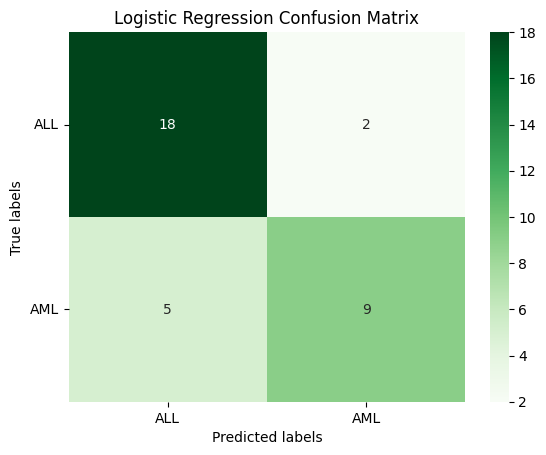

In [36]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                     'penalty': ['l1', 'l2']}
    
log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(df_significant_gene_train, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(df_significant_gene_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(['ALL', 'AML']) 
ax.yaxis.set_ticklabels(['ALL', 'AML'], rotation=360);

In [37]:
# Get predicted probabilities
log_prob = best_log.predict_proba(df_significant_gene_test)

# Combine actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test.iloc[:,1],
    'Predicted': log_pred,
    'Probability_ALL': log_prob[:, 0],  # P(class 0) = ALL
    'Probability_AML': log_prob[:, 1]   # P(class 1) = AML
})

# Map numeric labels to class names
class_mapping = {0: 'ALL', 1: 'AML'}
results_df['Actual_Class'] = results_df['Actual'].map(class_mapping)
results_df['Predicted_Class'] = results_df['Predicted'].map(class_mapping)

# Display
print("Predicted vs. Actual Values:")
print(results_df[['Probability_ALL', 'Probability_AML', 'Actual_Class', 'Predicted_Class']])

Predicted vs. Actual Values:
    Probability_ALL  Probability_AML Actual_Class Predicted_Class
0          0.966854         0.033146          ALL             ALL
1          0.972720         0.027280          ALL             ALL
2          0.894391         0.105609          ALL             ALL
3          0.977578         0.022422          ALL             ALL
4          0.999232         0.000768          ALL             ALL
5          0.957241         0.042759          ALL             ALL
6          0.973961         0.026039          ALL             ALL
7          0.746423         0.253577          ALL             ALL
8          0.974539         0.025461          ALL             ALL
9          0.921183         0.078817          ALL             ALL
10         0.524117         0.475883          ALL             ALL
11         0.689745         0.310255          AML             ALL
12         0.409311         0.590689          AML             AML
13         0.743419         0.256581          A

In [38]:
# Accuracy
accuracy = accuracy_score(y_test.iloc[:,1], log_pred)
print(f"Accuracy: {accuracy:.3f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test.iloc[:,1], log_pred, target_names=['ALL', 'AML']))

Accuracy: 0.794
Classification Report:
              precision    recall  f1-score   support

         ALL       0.78      0.90      0.84        20
         AML       0.82      0.64      0.72        14

    accuracy                           0.79        34
   macro avg       0.80      0.77      0.78        34
weighted avg       0.80      0.79      0.79        34



In [39]:
# Extract coefficients and intercept
df_coef = pd.DataFrame({
    'Gene': df_significant_gene_train.columns,
    'Coefficient': best_log.coef_[0]
})
intercept = best_log.intercept_[0]

# Sort by absolute value for importance
coef_df_sorted = df_coef.sort_values(by='Coefficient', key=abs, ascending=False)

# Display top contributors
print(f"Intercept (β0): {intercept:.3f}")
print("Top 10 Genes by Influence:")
print(coef_df_sorted.head(10))

Intercept (β0): -1.084
Top 10 Genes by Influence:
              Gene  Coefficient
30  U50136_rna1_at     0.862281
10       M80254_at     0.497743
33       X16546_at     0.467035
0        U49248_at    -0.435353
20       U19878_at     0.401104
28       X90872_at     0.388862
29       X66171_at     0.380699
18       X14046_at     0.372445
11     M31211_s_at    -0.370869
17       L09717_at     0.349912


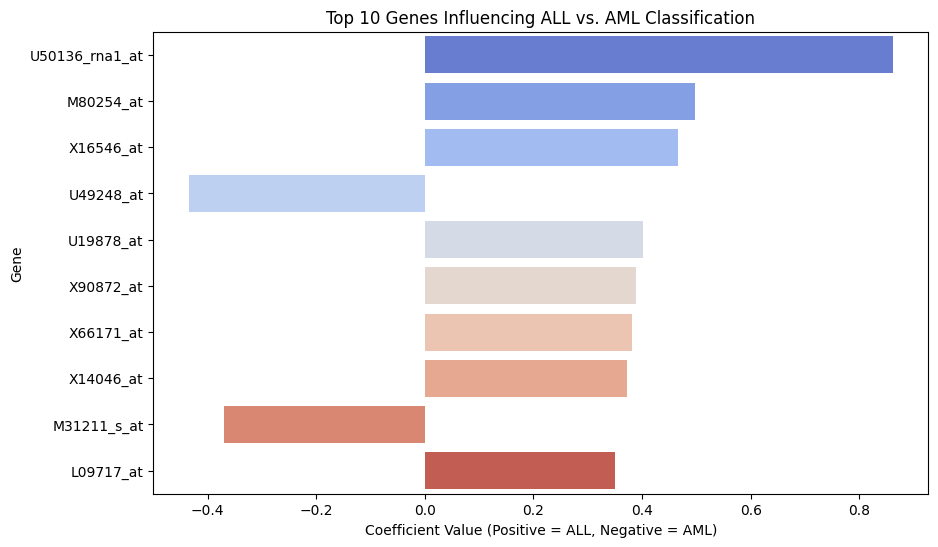

In [40]:
# Plot top 10 coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Gene', data=coef_df_sorted.head(10), palette='coolwarm')
plt.title('Top 10 Genes Influencing ALL vs. AML Classification')
plt.xlabel('Coefficient Value (Positive = ALL, Negative = AML)')
plt.ylabel('Gene')
plt.show()

In [41]:
# Take the first test sample
sample = df_significant_gene_test.iloc[0]
true_label = y_test.iloc[:,1][0]

# Get model-predicted probability (more reliable than manual computation)
log_prob = best_log.predict_proba(df_significant_gene_test.iloc[[0]])  # Double brackets for 2D input
prob_all = log_prob[0, 0]  # P(class 0) = ALL
prob_aml = log_prob[0, 1]  # P(class 1) = AML

# Predicted class based on probability
prediction = 'ALL' if prob_all > 0.5 else 'AML'

# Compute logit manually (for illustration, optional)
intercept = best_log.intercept_[0]
logit = intercept + sum(best_log.coef_[0] * sample)

# Top contributors for this sample
contributions = pd.DataFrame({
    'Gene': df_significant_gene_test.columns,
    'Value': sample,
    'Coefficient': best_log.coef_[0],
    'Contribution': best_log.coef_[0] * sample
})
top_contributors = contributions.sort_values(by='Contribution', key=abs, ascending=False).head(5)

# Print results
print(f"True Label: {'ALL' if true_label == 0 else 'AML'}")
print(f"Predicted Probability of ALL: {prob_all:.3f}")
print(f"Predicted Probability of AML: {prob_aml:.3f}")
print(f"Predicted Class: {prediction}")
print(f"Computed Logit (for reference): {logit:.3f}")
print("Top 5 Gene Contributions:")
print(top_contributors)

True Label: ALL
Predicted Probability of ALL: 0.967
Predicted Probability of AML: 0.033
Predicted Class: ALL
Computed Logit (for reference): -3.373
Top 5 Gene Contributions:
                            Gene     Value  Coefficient  Contribution
Gene Accession Number                                                
M80254_at              M80254_at -1.154255     0.497743     -0.574522
U49248_at              U49248_at  1.037265    -0.435353     -0.451576
X90872_at              X90872_at -1.057998     0.388862     -0.411415
U19878_at              U19878_at  1.022061     0.401104      0.409953
X66171_at              X66171_at -0.830571     0.380699     -0.316197


# Unsupervised Clustering with K-Means

In [42]:
print(df_significant_gene_train.shape)
print(y_train.shape)

(38, 34)
(38, 2)


In [43]:
df_combined_without_labels = df_combined.drop(['patient', 'cancer'], axis=1)
df_combined_without_labels = df_combined_without_labels[significant_genes['Gene Accession Number']]
print(df_combined_without_labels.shape)
df_combined_without_labels.head()

(72, 34)


,U49248_at,X74262_at,D38073_at,M69181_at,L13278_at,X17042_at,D32050_at,D63874_at,X81372_at,U05237_at,...,U31556_at,U20998_at,X84194_at,Z15115_at,X90872_at,X66171_at,U50136_rna1_at,D63391_at,U26266_s_at,X16546_at
0,0.837601,0.301921,0.520119,1.201059,1.039861,-0.921548,1.244235,-0.978053,1.410607,0.402562,...,0.646659,0.290436,0.187632,2.051335,-0.058534,0.347007,-0.360132,0.767614,-0.041053,-0.480675
1,-0.031526,0.106989,-0.422726,0.093433,-0.612535,0.071034,-0.787903,1.103572,0.768837,0.482235,...,-0.001344,0.135813,-1.434903,-0.595946,-0.048735,-1.485748,-0.431601,-1.624227,-0.044148,-0.241526
2,-0.430854,1.182224,1.446388,1.316374,1.090861,-0.849288,1.144060,1.263351,1.267992,0.740636,...,-0.047054,1.322616,0.461863,-0.109826,-0.141823,-1.389974,-0.044289,1.337763,0.447997,-0.388558
3,-0.266425,-0.030915,-0.130548,-1.020262,-0.000537,-0.856545,1.041839,0.239135,0.412298,-0.254208,...,-0.106208,0.017031,1.375967,0.353975,-0.367192,-0.305994,-0.569927,-0.556242,0.376806,-0.521419
4,0.825856,0.299847,0.428943,-0.995985,1.050061,1.435191,1.139971,0.546034,0.585474,0.286281,...,-0.431554,0.848509,1.798740,0.014747,1.734621,0.020507,-0.586065,0.414400,0.191091,0.401518


In [44]:
# Initialize K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit and predict clusters
cluster_labels = kmeans.fit_predict(df_combined_without_labels)

# Cluster labels (0 or 1, arbitrary assignment)
print("Cluster Labels:")
print(cluster_labels)

Cluster Labels:
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [45]:
# Contingency table: rows = clusters, columns = true labels (0 = ALL, 1 = AML)
contingency_table = confusion_matrix(y.iloc[:,1], cluster_labels)
print("Contingency Table (Clusters vs. True Labels):")
print(contingency_table)

# For each cluster, find the majority class and count correct assignments
correct_assignments = 0
for i in range(2):  # 2 clusters
    cluster_counts = contingency_table[i]  # Counts of ALL (0) and AML (1) in cluster i
    majority_class_count = np.max(cluster_counts)  # Most frequent class in this cluster
    correct_assignments += majority_class_count

# Total samples
total_samples = len(y.iloc[:,1])

# Purity
purity = correct_assignments / total_samples
print(f"Purity of Clustering: {purity:.3f}")

Contingency Table (Clusters vs. True Labels):
[[35 12]
 [ 1 24]]
Purity of Clustering: 0.819


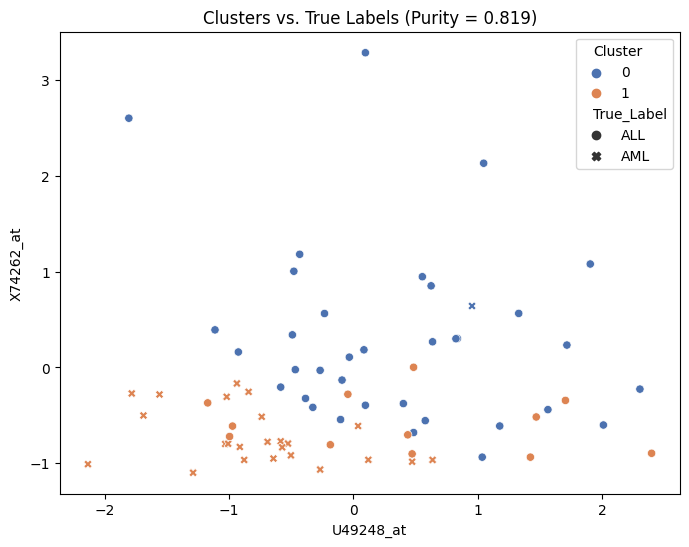

In [46]:
# Add cluster labels to DataFrame
df_with_clusters = df_combined_without_labels.copy()
df_with_clusters['Cluster'] = cluster_labels
df_with_clusters['True_Label'] = y.iloc[:,1].map({0: 'ALL', 1: 'AML'})

# Example: Plot first two features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_combined_without_labels.iloc[:, 0], y=df_combined_without_labels.iloc[:, 1], hue=df_with_clusters['Cluster'], 
                style=df_with_clusters['True_Label'], palette='deep')
plt.title(f'Clusters vs. True Labels (Purity = {purity:.3f})')
plt.xlabel(df_combined_without_labels.columns[0])
plt.ylabel(df_combined_without_labels.columns[1])
plt.show()